# 프로젝트: 한영 번역기 만들기

### 데이터
- [다운로드](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)
- korean-english-park.train.tar.gz 이용

In [132]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [133]:
# git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
# ls
# cd Mecab-ko-for-Google-Colab
# ls
# bash install_mecab-ko_on_colab190912.sh

In [134]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq

In [135]:
# 한글 폰트 셋팅
import matplotlib as mpl
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=14).get_name()
plt.rc('font', family=font)
fm._rebuild()

In [136]:
import io
import os
import random
import re
import time
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker

from konlpy.tag import Mecab

## 데이터 준비

In [137]:
# !cd ~/aiffel/aiffel_projects/goingdeeper/GD8_s2s_translation

In [138]:
# !tar -zxvf korean-english-park.train.tar.gz
# !tar -zxvf korean-english-park.test.tar.gz

In [139]:
# base_path = os.getenv('HOME') + '/aiffel/aiffel_projects/goingdeeper/GD8_s2s_translation'
ko_train = '/korean-english-park.train.ko'
en_train = '/korean-english-park.train.en'

In [140]:
with open(ko_train, 'r') as f:
    ko_raw = f.read().splitlines()
    
print('Data Size:', len(ko_raw))
print('Example:')
for sen in ko_raw[:5]:
    print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.
>> 그러나 이것은 또한 책상도 필요로 하지 않는다.
>> 79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.
>> 정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.


In [141]:
with open(en_train, 'r') as f:
    en_raw = f.read().splitlines()
    
print('Data Size:', len(en_raw))
print('Example:')
for sen in en_raw[:5]:
    print(">>", sen)

Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable, wireless mouse.
>> Like all optical mice, But it also doesn't need a desk.
>> uses gyroscopic sensors to control the cursor movement as you move your wrist, arm, whatever through the air.
>> Intelligence officials have revealed a spate of foiled plots on ships in Southeast Asia and are warning that a narrow stretch of water carrying almost one third of the world's maritime trade is vulnerable to a terror attack.


In [142]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r"\1", sentence)
    sentence = re.sub(r'[""]+', " ", sentence)
    sentence = re.sub(r"[^a-zㄱ-ㅎㅏ-ㅣ가-힣0-9?.!,]+", " ", sentence)
    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence
    if e_token:
        sentence += ' <end>'
    
    return sentence

In [143]:
ko_corpus = []
en_corpus = []

for sen in ko_raw:
    ko_corpus.append(preprocess_sentence(sen))
    
for sen in en_raw:
    en_corpus.append(preprocess_sentence(sen, s_token=True, e_token=True))
    
print('ko_corpus size:', len(ko_corpus))
print('en_corpus size:', len(en_corpus))
print('---------------')
print('Korean:', ko_corpus[100])
print('---------------')
print('English:', en_corpus[100])

ko_corpus size: 94123
en_corpus size: 94123
---------------
Korean: 제 23차 연례 컴덱스 박람회의 개회사를 한 케이츠는 2년여전 기술 산업의 거품이 붕괴된 이후에 첨단 기술에 대해 부정적인 인식이 있다고 말했다.
---------------
English: <start> gates, who opened the 23rd annual comdex trade show, said there was a negative perception of high tech following the collapse of the tech bubble about two years ago. <end>


In [144]:
# 중복 문장 제거
cleaned_corpus = [(ko, en) for ko, en in zip(ko_corpus, en_corpus)]
cleaned_corpus = list(set(cleaned_corpus))

print('cleaned_corpus size:', len(cleaned_corpus))

cleaned_corpus size: 78932


In [145]:
cleaned_corpus[1]

('위원회는 또 유럽위원회는 터키의 총선과 대통령 선거가 외부의 개입 없이 민주적인 방식에 의해 정치적인 안정 속에서 치러지는 것을 희망한다 고 밝혔다.',
 '<start> the commission expects that the parliamentary and presidential elections will be carried out democratically without any undue interference, and in an atmosphere of responsible debate and political stability, it added. <end>')

In [146]:
ko_corpus = [ko for ko, _ in cleaned_corpus if len(ko) <= 50]
en_corpus = [en for ko, en in cleaned_corpus if len(ko) <= 50]

print('ko_corpus size:', len(ko_corpus))
print('en_corpus size:', len(en_corpus))

ko_corpus size: 26557
en_corpus size: 26557


In [147]:
print('ko_corpus size:', ko_corpus[1])
print('en_corpus size:', en_corpus[1])

ko_corpus size: 미국 힙합을 연상시키는 비트에 맞춰 대중 앞에 선 화이트는 노래를 시작했다.
en_corpus size: <start> the japanese crowd heard a beat reminiscent of american style hip hop but then white started to sing. <end>


## 토큰화

In [148]:
MAX_LEN = 40
VOCAB_SIZE = 10000

def tokenize(corpus, max_len=MAX_LEN, kor=False):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', num_words=VOCAB_SIZE)
    
    if kor:        
        mecab = Mecab()
        morphs = [" ".join(mecab.morphs(sen)) for sen in corpus]
       
        tokenizer.fit_on_texts(morphs)

        tensor = tokenizer.texts_to_sequences(morphs)
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, maxlen=max_len, padding='post')
    else:
        tokenizer.fit_on_texts(corpus)

        tensor = tokenizer.texts_to_sequences(corpus)
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, maxlen=max_len, padding='post')

    return tensor, tokenizer

In [149]:
enc_tensor, enc_tokenizer = tokenize(ko_corpus, MAX_LEN, kor=True)
dec_tensor, dec_tokenizer = tokenize(en_corpus, MAX_LEN)

print('Korean Vocab Size:', len(enc_tokenizer.index_word))
print('English Vocab Size:', len(dec_tokenizer.index_word))

Korean Vocab Size: 24901
English Vocab Size: 35222


## 모델 설계

In [150]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [151]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units, return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

In [152]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [153]:
BATCH_SIZE = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units = 128
embedding_dim = 128

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 40

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 40, 128)
Decoder Output: (64, 35223)
Decoder Hidden State: (64, 128)
Attention: (64, 40, 1)


In [154]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

In [155]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0
    
    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']]*bsz, 1)
        
        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)
            
            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
            
        batch_loss = (loss/int(tgt.shape[1]))
        
        variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
        
        return batch_loss

In [156]:
EPOCHS = 30

for epoch in range(EPOCHS):
    # train
    total_loss = 0
    
    idx_list = list(range(0, enc_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_tensor[idx:idx+BATCH_SIZE],
                                dec_tensor[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 30: 100%|██████████| 415/415 [00:42<00:00,  9.75it/s, Loss 1.3926]


In [157]:
# 번역 성능 평가하는 함수
# 보너스로 attention map 시각화
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_tensor.shape[-1], enc_tensor.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=enc_tensor.shape[-1],
                                                          padding='post')
    
    result = ''
    
    enc_out = encoder(inputs)
    
    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)
    
    for t in range(dec_tensor.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                            dec_hidden,
                                                            enc_out)
        attention_weights = tf.reshape(attention_weights, (-1))
        attention[t] = attention_weights.numpy()
        
        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()
        
        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))

Input: 커피가 필요해
Predicted translation: and <end> 


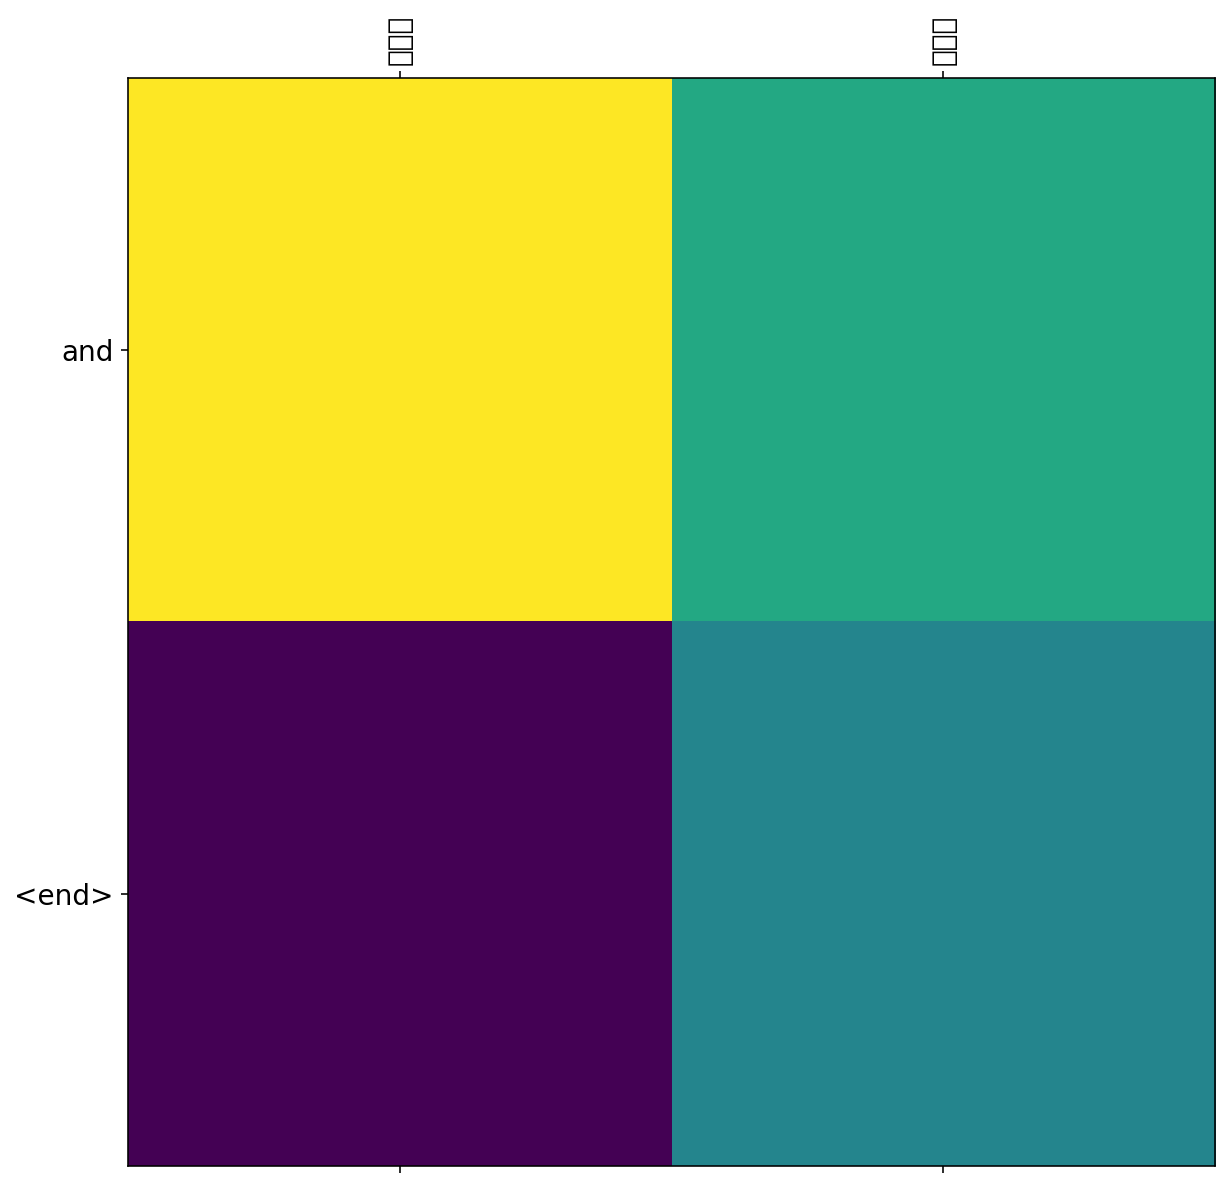

In [158]:
translate("커피가 필요해", encoder, decoder)

Input: 한글이 출력이 안 된다 또
Predicted translation: it s a lot of the <end> 


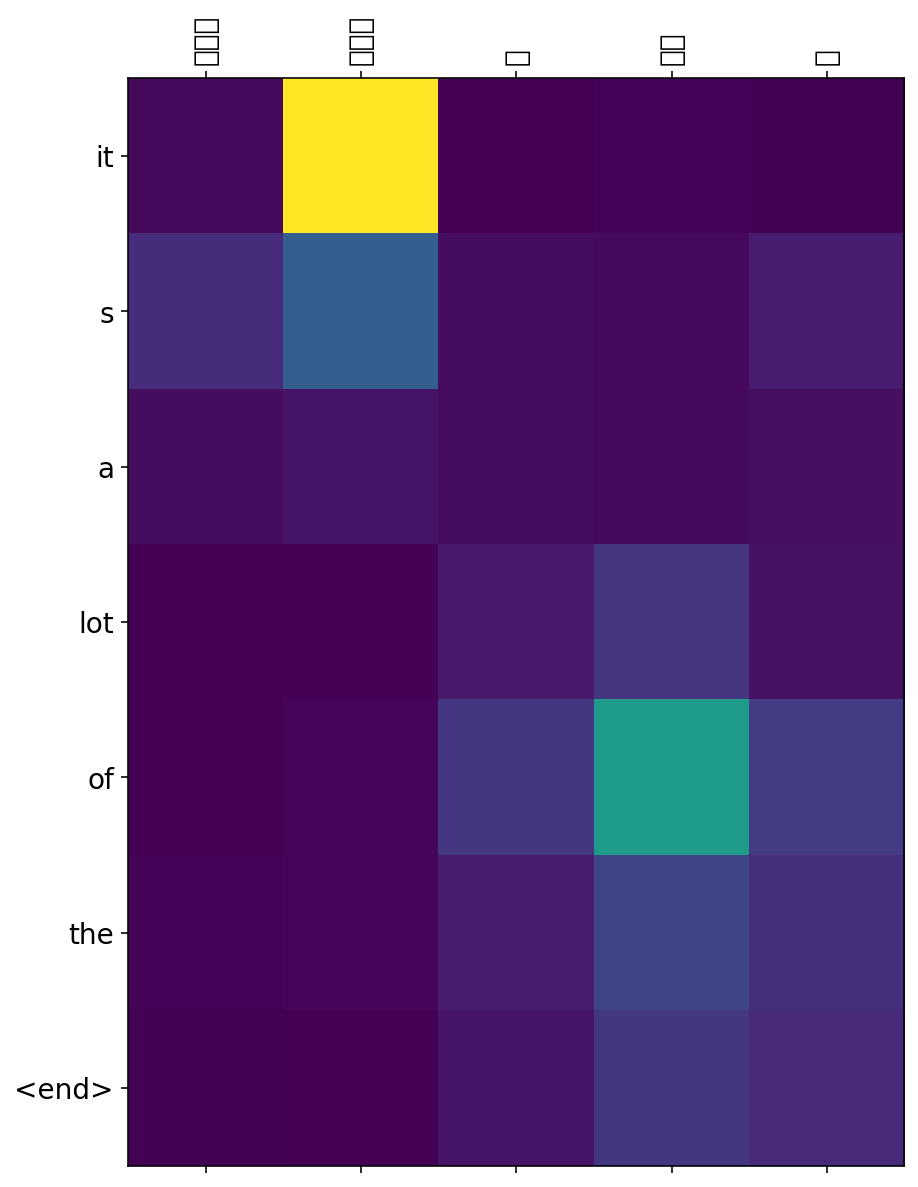

In [160]:
translate("한글이 출력이 안 된다 또", encoder, decoder)

Input: 아시아에서는 한국과 중국이 가입했다.
Predicted translation: and <end> 


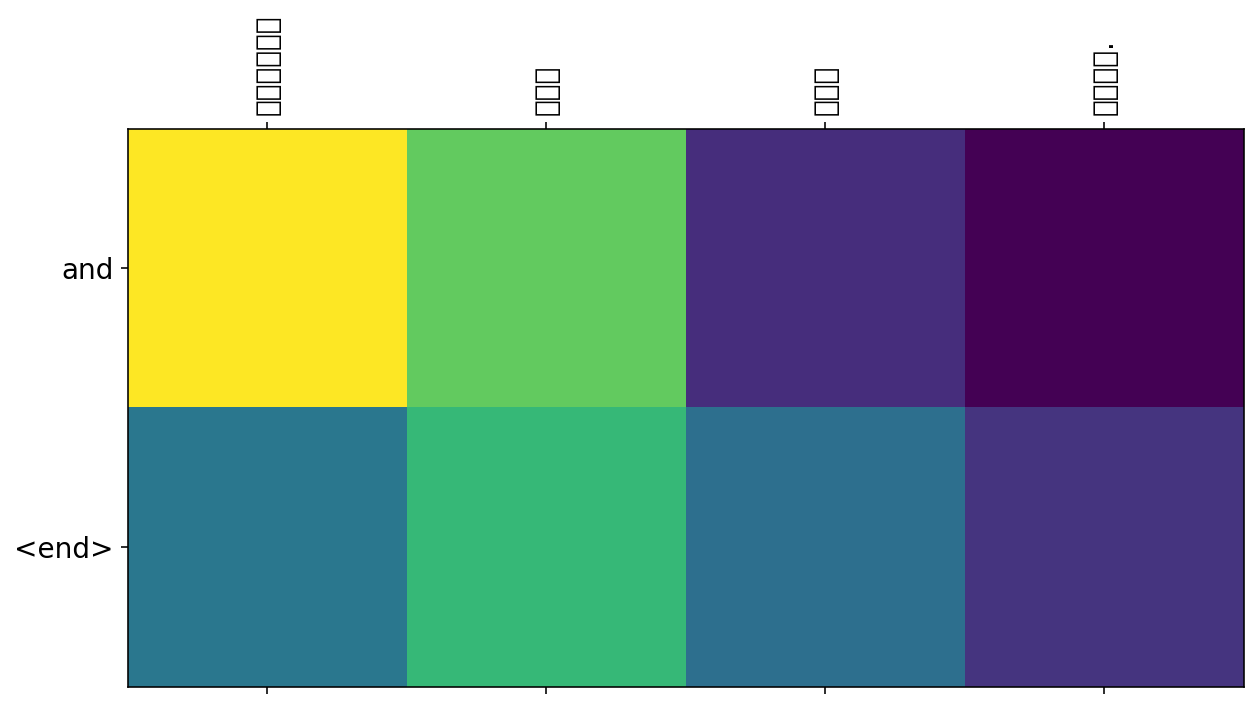

In [161]:
translate("아시아에서는 한국과 중국이 가입했다.", encoder, decoder)

Input: 원래 가을 기후를 되찾을 것이다.
Predicted translation: a second first a little <end> 


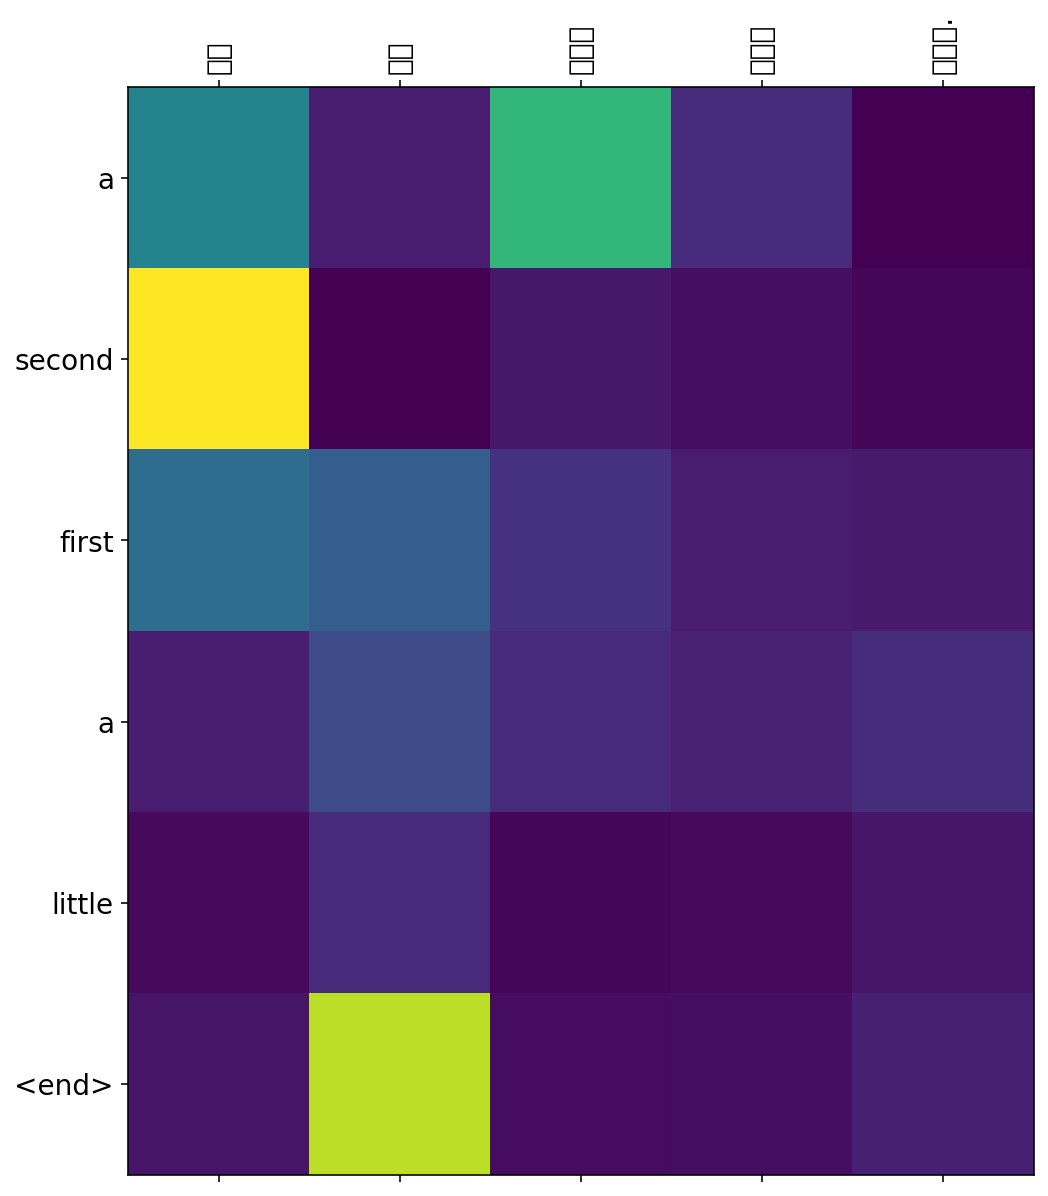

In [166]:
translate("원래 가을 기후를 되찾을 것이다.", encoder, decoder)